# Machine Learning in Chess to Study Patterns in Chess Games


## Import Libraries


In [102]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Load the Data


In [103]:
DATA_PATH = "/Users/isaac/Downloads/ChessDBs/lichess_db_standard_rated_2022"
# Check whether the DataFrame has been loaded correctly.
df = dd.read_parquet(DATA_PATH, engine="pyarrow")
print(f"Loaded {len(df)} Rated Bullet, Rated Blitz, and Rated Rapid games from 2022.\n")
display(df)
display(df.head())


Loaded 63927025 Rated Bullet, Rated Blitz, and Rated Rapid games from 2022.



,UTCDateTime,Event,TimeControl,Result,Termination,ECO,Opening,White,Black,WhiteElo,BlackElo,Site
npartitions=153,,,,,,,,,,,,
,datetime64[ns],category[unknown],string,category[unknown],category[unknown],string,string,string,string,int16,int16,string
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


,UTCDateTime,Event,TimeControl,Result,Termination,ECO,Opening,White,Black,WhiteElo,BlackElo,Site
0,2022-01-01 00:00:11,Rated Bullet game,120+1,0-1,Normal,D02,Queen's Pawn Game: Chigorin Variation,Kike73,Aox066,1255,1252,https://lichess.org/BPNsj2LF
1,2022-01-01 00:00:11,Rated Bullet game,120+1,1-0,Normal,C40,King's Pawn Game: Busch-Gass Gambit,schachueli,HiddenEyes,1346,1308,https://lichess.org/ooDjyGrm
2,2022-01-01 00:00:11,Rated Bullet game,120+1,0-1,Time forfeit,C02,"French Defense: Advance Variation, Nimzowitsch...",Renf7,Euphorbe92,859,964,https://lichess.org/T4TIdZZM
3,2022-01-01 00:00:11,Rated Bullet game,120+1,0-1,Time forfeit,B10,Caro-Kann Defense: Accelerated Panov Attack,Ralza63,FN2718,1769,1702,https://lichess.org/Oz5OFohi
4,2022-01-01 00:00:11,Rated Bullet game,120+1,1-0,Time forfeit,A41,Queen's Pawn Game,arkchess1963,sirkkeli,2146,2196,https://lichess.org/iehbAAzy


## Get Most Popular Openings


In [104]:
# Group variations of the same opening together by splitting on the colon.
opening_groups = df["Opening"].str.split(":").str[0].value_counts().compute()
display(opening_groups)


Sicilian Defense        6799525
Queen's Pawn Game       5274310
French Defense          3679831
Scandinavian Defense    3376155
Caro-Kann Defense       2918453
                         ...   
Venezolana Opening           72
Formation                    47
Dresden Opening              21
Veresov Opening              19
Amar Gambit                  18
Name: Opening, Length: 162, dtype: int64

/var/folders/qp/xjhbjb791c527d9nwvbnwz8m0000gn/T/ipykernel_89345/2746060185.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(indexes, rotation=45)


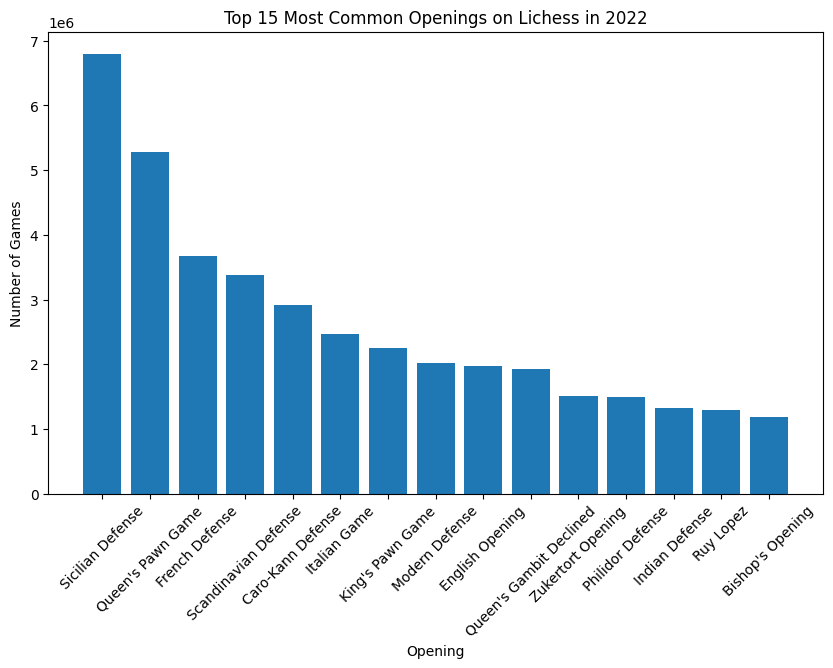

In [105]:
# Plot the top 15 most common openings.
fig, ax = plt.subplots(figsize=(10, 6))
indexes = opening_groups.index[:15]
values = opening_groups.values[:15]
ax.bar(indexes, values)
ax.set_xticklabels(indexes, rotation=45)
ax.set_title("Top 15 Most Common Openings on Lichess in 2022")
ax.set_xlabel("Opening")
ax.set_ylabel("Number of Games")
plt.show()


## Get Most Popular Opening Categories


In [106]:
opening_categories = df["ECO"].str[0].value_counts().compute()
display(opening_categories)


C    19719467
B    18273490
A    16472856
D     8441510
E      984018
?       35684
Name: ECO, dtype: Int64

/var/folders/qp/xjhbjb791c527d9nwvbnwz8m0000gn/T/ipykernel_89345/1498455107.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


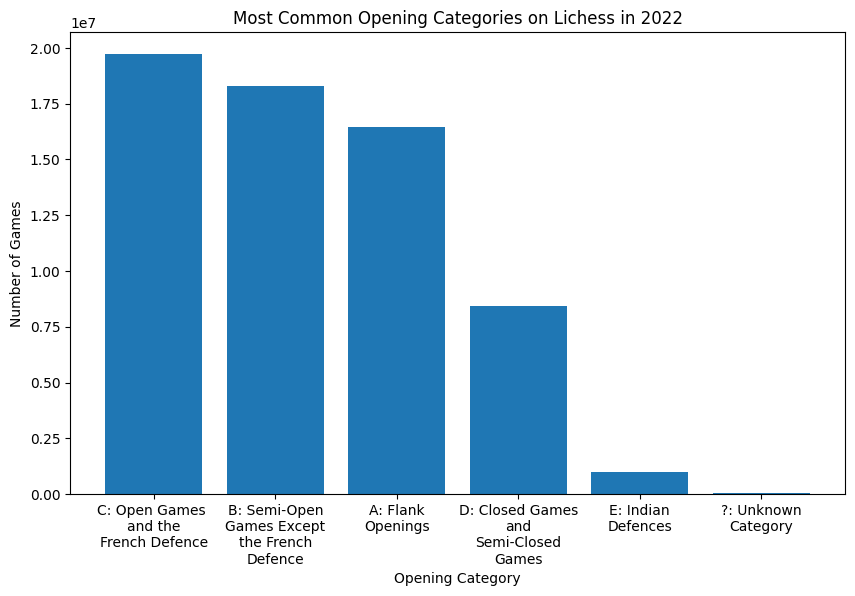

In [133]:
# Map each opening category to its type.
opening_category_map = {
    "A": "Flank\nOpenings",
    "B": "Semi-Open\nGames Except\nthe French\nDefence",
    "C": "Open Games \nand the\nFrench Defence",
    "D": "Closed Games\nand\nSemi-Closed\nGames",
    "E": "Indian\nDefences",
    "?": "Unknown\nCategory",
}

# Plot the number of games in each opening category.
fig, ax = plt.subplots(figsize=(10, 6))
indexes = opening_categories.index
values = opening_categories.values
ax.bar(indexes, values)
ax.set_title("Most Common Opening Categories on Lichess in 2022")
ax.set_xlabel("Opening Category")
ax.set_ylabel("Number of Games")
ax.set_xticklabels(
    [str(f"{index}: {opening_category_map[index]}") for index in indexes]
)
plt.show()


## Get Elo Distribution of Players


In [108]:
white_elo_count = df["WhiteElo"].value_counts().compute()
black_elo_count = df["BlackElo"].value_counts().compute()

# Merge the counts into one, as the player's side isn't important.
elo_counts = pd.concat([white_elo_count, black_elo_count], axis=1).fillna(0).astype(int)
elo_counts = elo_counts.sum(axis=1)
# Find the maximum ELO rating.
max_elo = elo_counts.index.max()
print(f"Maximum ELO rating: {max_elo}")

# Define the bin edges for ELO ratings from 600 (minimum ELO in Lichess) to the
# maximum ELO in intervals of 200.
bin_size = 200
elo_bins = np.array([i for i in range(600, max_elo + bin_size, bin_size)])
elo_counts.index = pd.cut(elo_counts.index, bins=elo_bins)
merged_elo_counts = elo_counts.groupby(level=0).sum()
display(merged_elo_counts)


Maximum ELO rating: 3485


(600, 800]       1036347
(800, 1000]      4869159
(1000, 1200]    11242416
(1200, 1400]    17564485
(1400, 1600]    23150584
(1600, 1800]    25317906
(1800, 2000]    22498480
(2000, 2200]    14115285
(2200, 2400]     5816418
(2400, 2600]     1709222
(2600, 2800]      420496
(2800, 3000]       73395
(3000, 3200]        7295
(3200, 3400]         459
(3400, 3600]           1
dtype: int64

/var/folders/qp/xjhbjb791c527d9nwvbnwz8m0000gn/T/ipykernel_89345/1289568337.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(indexes, rotation=45)


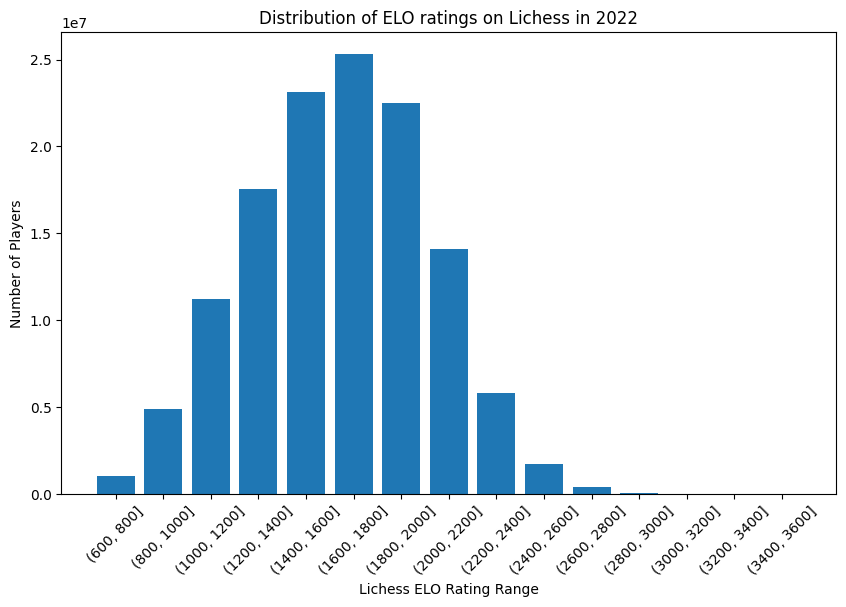

In [109]:
# Plot a graph to show the distribution of ELO ratings.
fig, ax = plt.subplots(figsize=(10, 6))
indexes = merged_elo_counts.index.astype(str)
values = merged_elo_counts.values
ax.bar(indexes, values)
ax.set_title("Distribution of ELO ratings on Lichess in 2022")
ax.set_xlabel("Lichess ELO Rating Range")
ax.set_ylabel("Number of Players")
ax.set_xticklabels(indexes, rotation=45)
plt.show()